# 現実写真のみ、文字なし、固有名詞含む、キャプション、ほかの画像の大喜利

In [15]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
EXPERIENCE_NUMBER = "003"

USE_UNREAL_IMAGE = False
USE_WORD_IMAGE = False
USE_UNIQUE_NOUN_BOKE = True
USE_CAPTION = True
USE_MISS_BOKE = True

EPOCH = 25
BATCH_SIZE = 256

RESULT_DIR = f"../../results/Boke_Judge/{EXPERIENCE_NUMBER}/"
if not os.path.exists("../../results/Boke_Judge/"):
    os.mkdir("../../results/Boke_Judge/")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

DATA_DIR = "../../datas/boke_data_assemble/"
CLIP_IMAGE_FEATURE_DIR = "../../datas/encoded/clip_image_feature/"
CLIP_SENTENCE_FEATURE_DIR = "../../datas/encoded/clip_sentence_feature/"
LUKE_SENTENCE_FEATURE_DIR = "../../datas/encoded/luke_sentence_feature/"

# データセットの作成(初回のみ実行)

In [3]:
boke_datas = list()
caption_datas = list()

max_num_boke = 0
for JP in tqdm(os.listdir(DATA_DIR)):
    N = int(JP.split(".")[0])

    with open(f"{DATA_DIR}{JP}", "r") as f:
        a = json.load(f)

    image_information = a["image_infomation"]
    is_photographic_probability = image_information["is_photographic_probability"]
    ja_caption = image_information["ja_caption"]
    ocr = image_information["ocr"]

    # 現実写真以外を除去
    if not USE_UNREAL_IMAGE:
        if is_photographic_probability < 0.8: continue
        
    # 文字のある画像を除去
    if not USE_WORD_IMAGE:
        if len(ocr) != 0: continue

    bokes = a["bokes"]

    max_num_boke = max(max_num_boke, len(a["bokes"]))
    for i, B in enumerate(bokes):

        # 固有名詞を含む大喜利を除去
        if not USE_UNIQUE_NOUN_BOKE:
            if len(B["unique_nouns"]) != 0: continue

        boke_datas.append({
            "boke_number": int(f"1{N:07}{i:05}"),
            "image_number": int(f"3{N:07}")
        })

    caption_datas.append({
        "caption_number": int(f"2{N:07}"),
        "image_number": int(f"3{N:07}")
    })

len(boke_datas), len(caption_datas)

100%|██████████| 602566/602566 [01:59<00:00, 5046.40it/s]


(2183708, 230990)

In [4]:
train_boke_datas, test_boke_datas = train_test_split(boke_datas, test_size = 0.01)
train_caption_datas, test_caption_datas = train_test_split(caption_datas, test_size = 0.01)

with open(f"{RESULT_DIR}train_boke_datas.json", "w") as f:
    json.dump(train_boke_datas, f)
with open(f"{RESULT_DIR}train_caption_datas.json", "w") as f:
    json.dump(train_caption_datas, f)

with open(f"{RESULT_DIR}test_boke_datas.json", "w") as f:
    json.dump(test_boke_datas, f)
with open(f"{RESULT_DIR}test_caption_datas.json", "w") as f:
    json.dump(test_caption_datas, f)

# モデルの学習

In [5]:
with open(f"{RESULT_DIR}train_boke_datas.json", "r") as f:
    train_boke_datas = json.load(f)
with open(f"{RESULT_DIR}train_caption_datas.json", "r") as f:
    train_caption_datas = json.load(f)

with open(f"{RESULT_DIR}test_boke_datas.json", "r") as f:
    test_boke_datas = json.load(f)
with open(f"{RESULT_DIR}test_caption_datas.json", "r") as f:
    test_caption_datas = json.load(f)

len(train_boke_datas), len(train_caption_datas), len(test_boke_datas), len(test_caption_datas)

(2161870, 228680, 21838, 2310)

In [6]:
def make_dataloader(boke_datas, caption_datas):
    class LoadNpyDataset(Dataset):
        def __init__(self, image_file_numbers, sentence_file_numbers, teacher_signals):
            if len(image_file_numbers) != len(sentence_file_numbers) and len(sentence_file_numbers) != len(teacher_signals):
                raise ValueError("データリストの長さが一致しません")

            self.image_file_numbers = image_file_numbers
            self.sentence_file_numbers = sentence_file_numbers
            self.teacher_signals = teacher_signals

        def __len__(self):
            return len(self.teacher_signals)

        def __getitem__(self, idx):
            clip_image_feature = np.load(f"{CLIP_IMAGE_FEATURE_DIR}{self.image_file_numbers[idx]}.npy")
            clip_sentence_feature = np.load(f"{CLIP_SENTENCE_FEATURE_DIR}{self.sentence_file_numbers[idx]}.npy")
            luke_sentence_feature = np.load(f"{LUKE_SENTENCE_FEATURE_DIR}{self.sentence_file_numbers[idx]}.npy")
            teacher_signal = self.teacher_signals[idx]

            return clip_image_feature, clip_sentence_feature, luke_sentence_feature, teacher_signal

    def collate_fn_tf(batch):
        clip_image_features = np.array([B[0] for B in batch])
        clip_sentence_features = np.array([B[1] for B in batch])
        luke_sentence_features = np.array([B[2] for B in batch])
        teacher_signals = np.array([float(B[3]) for B in batch])
        
        return clip_image_features, clip_sentence_features, luke_sentence_features, teacher_signals

    #
    image_file_numbers = list()
    sentence_file_numbers = list()
    teacher_signals = list()

    for D in boke_datas:
        image_file_numbers.append(D["image_number"])
        sentence_file_numbers.append(D["boke_number"])
        teacher_signals.append(1)

    if USE_CAPTION:
        for D in caption_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["caption_number"])
            teacher_signals.append(0)
    
    if USE_MISS_BOKE:
        miss_boke_datas = list()
        tmp_idx = np.random.randint(0, len(boke_datas), size = (len(boke_datas), ))
        for i, idx in tqdm(enumerate(tmp_idx)):
            tmp_boke_number = boke_datas[idx]["boke_number"]
            while str(tmp_boke_number)[:7] == str(boke_datas[i]["boke_number"])[:7]:
                idx = np.random.randint(0, len(boke_datas))
                tmp_boke_number = boke_datas[idx]["boke_number"]

            miss_boke_datas.append({
                "boke_number": tmp_boke_number,
                "image_number": boke_datas[i]["image_number"]
            })
        
        for D in miss_boke_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["boke_number"])
            teacher_signals.append(0)
    
    print(f"num data: {len(teacher_signals)}")

    tmp = list(zip(image_file_numbers, sentence_file_numbers, teacher_signals))
    np.random.shuffle(tmp)
    image_file_numbers, sentence_file_numbers, teacher_signals = zip(*tmp)

    dataset = LoadNpyDataset(image_file_numbers, sentence_file_numbers, teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = 10, 
        collate_fn = collate_fn_tf
    )

    return dataloader

train_dataloader = make_dataloader(train_boke_datas, train_caption_datas)
test_dataloader = make_dataloader(test_boke_datas, test_caption_datas)

#
CIF, CSF, LSF, TS = next(iter(train_dataloader))
CIF.shape, CSF.shape, LSF.shape, TS.shape

2161870it [00:02, 848080.01it/s]


num data: 4552420


21838it [00:00, 57706.02it/s]

num data: 45986


((256, 512), (256, 512), (256, 768), (256,))

In [19]:
class CustomModel(nn.Module):
    def __init__(self, cif_dim, csf_dim, lsf_dim):
        super(CustomModel, self).__init__()
        # 入力次元を設定
        self.cif_dim = cif_dim
        self.csf_dim = csf_dim
        self.lsf_dim = lsf_dim
        
        # 全結合層
        self.fc1 = nn.Linear(cif_dim + csf_dim + lsf_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 1)
        
    def forward(self, cif, csf, lsf):
        # 入力を結合
        x = torch.cat([cif, csf, lsf], dim=1)
        # 全結合層 + LeakyReLU
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        # 出力層 + シグモイド
        output = torch.sigmoid(self.output_layer(x))
        return output

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
print(model)

CustomModel(
  (fc1): Linear(in_features=1792, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=1, bias=True)
)


In [21]:
def train_step(model, optimizer, batch_data, batch_labels):
    model.train()  # モデルを訓練モードに設定
    optimizer.zero_grad()  # 勾配を初期化
    outputs = model(*batch_data).float()  # モデルで予測を計算
    loss = nn.BCELoss()(outputs, batch_labels.float())  # 損失関数（バイナリクロスエントロピー）
    accuracy = ((outputs > 0.5).float() == batch_labels).float().mean()  # 精度計算
    loss.backward()  # 勾配を計算
    optimizer.step()  # パラメータ更新
    return loss.item(), accuracy.item()

def evaluate(model, batch_data, batch_labels):
    model.eval()  # モデルを評価モードに設定
    with torch.no_grad():  # 評価時に勾配計算を行わない
        outputs = model(*batch_data)
        loss = nn.BCELoss()(outputs, batch_labels)
        accuracy = ((outputs > 0.5).float() == batch_labels).float().mean()
    return loss.item(), accuracy.item()

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
optimizer = optim.AdamW(model.parameters(), lr = 0.0001)

# 訓練・評価ループ
for epoch in range(EPOCH):
    # 訓練
    train_loss_obj = 0.0
    train_accuracy_obj = 0.0
    model.train()  # 訓練モード
    train_dataloader = make_dataloader(train_boke_datas, train_caption_datas)
    pb = tqdm(train_dataloader, desc = f"Epoch {epoch+1}/{EPOCH}")
    
    for CIF, CSF, LSF, TS in pb:
        CIF, CSF, LSF, TS = torch.tensor(CIF), torch.tensor(CSF), torch.tensor(LSF), torch.tensor(TS)
        batch_data = (CIF, CSF, LSF)  # 入力データ
        batch_labels = TS.unsqueeze(1)  # 出力ラベル（shape: [batch_size, 1]）
        
        loss, accuracy = train_step(model, optimizer, batch_data, batch_labels)
        train_loss_obj += loss
        train_accuracy_obj += accuracy
        pb.set_postfix({"train_loss": train_loss_obj / (pb.n + 1), "train_accuracy": train_accuracy_obj / (pb.n + 1)})

    # 訓練後の損失と精度
    train_loss = train_loss_obj / len(train_dataloader)
    train_accuracy = train_accuracy_obj / len(train_dataloader)

    # テスト
    test_loss_obj = 0.0
    test_accuracy_obj = 0.0
    model.eval()  # 評価モード
    test_dataloader = make_dataloader(test_boke_datas, test_caption_datas)
    pb = tqdm(test_dataloader, desc = "Evaluating")

    for CIF, CSF, LSF, TS in pb:
        CIF, CSF, LSF, TS = torch.tensor(CIF).float(), torch.tensor(CSF).float(), torch.tensor(LSF).float(), torch.tensor(TS).float()
        batch_data = (CIF, CSF, LSF)
        batch_labels = TS.unsqueeze(1).float()
        
        loss, accuracy = evaluate(model, batch_data, batch_labels)
        test_loss_obj += loss
        test_accuracy_obj += accuracy
        pb.set_postfix({"test_loss": test_loss_obj / (pb.n + 1), "test_accuracy": test_accuracy_obj / (pb.n + 1)})

    # テスト後の損失と精度
    test_loss = test_loss_obj / len(test_dataloader)
    test_accuracy = test_accuracy_obj / len(test_dataloader)

    # 結果表示
    print(f"Epoch: {epoch+1}/{EPOCH}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # 履歴の保存
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

# 結果をJSONファイルに保存
with open(f"{RESULT_DIR}history.json", "w") as f:
    json.dump({
        "train_loss": train_loss_history,
        "train_accuracy": train_accuracy_history,
        "test_loss": test_loss_history,
        "test_accuracy": test_accuracy_history
    }, f)


2161870it [00:02, 731693.60it/s]


num data: 4552420


Epoch 1/25: 100%|██████████| 17783/17783 [08:29<00:00, 34.89it/s, train_loss=0.595, train_accuracy=0.658]
21838it [00:00, 305643.39it/s]


num data: 45986


Evaluating: 100%|██████████| 180/180 [00:02<00:00, 68.46it/s, test_loss=0.571, test_accuracy=0.692] 


Epoch: 1/25, Train Loss: 0.5952, Train Accuracy: 0.6577, Test Loss: 0.5678, Test Accuracy: 0.6883


2161870it [00:03, 594721.09it/s]


num data: 4552420


Epoch 2/25:   2%|▏         | 381/17783 [00:12<07:49, 37.05it/s, train_loss=0.567, train_accuracy=0.692]

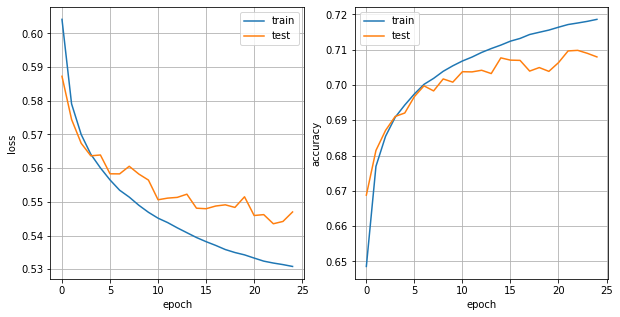

In [18]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_accuracy_history, label = "train")
ax.plot(test_accuracy_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
ax.grid()